# ELM 463 DÖNEM PROJESİ
# GÖRSELLERDE İNSAN TESPİTİ VE SOSYAL MESAFE UYUMLULUĞU
# ALPEREN KARATAŞ - 1801022022, OGÜN UYGAR YILDIRIM - 1801022091

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import cv2 as cv # Opencv Kütüphanesi
from imutils import perspective
import argparse
import imutils
from __future__ import print_function
from imutils import contours

In [2]:
def peopleCounter(image):
    original_img = cv.imread(image,0) 

    # konturleri siralama islemi icin kullanilan fonskiyon
    def order_points_old(pts):

        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
       
    # sosyal mesafenin ihlal edilip edilmedigini siyah veya beyaz cizgi cizerek kontrol eden fonksiyon
    def drawSocialDistanceLines(img,list_val,ym1): 
        
        color_valid = (255, 255, 255)   # sosyal mesafe uygunsa beyaz cizgi cizen renk kodu
        color_not_valid = (0, 0, 0)     # sosyal mesafe ihlal edilirse siyah cizgi cizen renk kodu
        thickness = 3                   # cizginin kalinligi
        
        # tespit icin mesafe kontrolu yapilacak
        for i in range(0,len(list_val)):
            for j in range(1,len(list_val)):
                if(j==2):               
                    ym1 = ym1 + 50      # cizilen cizgilerin ust uste binmemesi icin y eksenin kaydirma 
                start_point = (int(list_val[i]),int(ym1))  # cizginin baslangic noktasi
                end_point = (int(list_val[j]),int(ym1))    # cizginin bitis noktasi (x ekseni boyunca cizilecegi icin ym1 sabit)
                dist = abs(list_val[i]-list_val[j])        # mesafenin olcumu
                if(dist<240):                              # sosyal mesafeye uygunluk kontrolu
                    image = cv.line(img, start_point, end_point, color_not_valid, thickness)   # sosyal mesafe ihlali varsa siyah cizgi
                else:
                    image = cv.line(img, start_point, end_point, color_valid, thickness)   # sosyal mesafe uygunsa beyaz cizgi
        return image
    
    # mesafelerin bulundugu listedeki sifirlar ve tekrarlari yok etmek icin olusturulan fonksiyon
    def removeZerosAndSame(dist_check,dist_list):
        
        if(dist_check==0.0):
            dist_list.remove(dist_check)  # sifirlarin yok edilmesi
        dist_list = list(set(dist_list))  # tekrarlarin yok edilmesi
        return dist_list
                
    # mesafelerin tespitinin yapildigi fonksiyon
    def socialDistance(values_list):
        
        for i in range(0,len(values_list)): 
            for j in range(0,len(values_list)):
                dist = abs(values_list[i]-values_list[j])  # mesafe bulunuyor
                distance_list.append(dist)                 # bulunan mesafeler yeni bir listeye ekleniyor
                new_dist_list = removeZerosAndSame(dist,distance_list)  # sifirlar ve tekrarlarin kaldirilmasi icin fonksiyoa yollaniyor
        print("new dist list",new_dist_list)
        return new_dist_list
        
    import sys 
    sys.argv=['']
    del sys
    
    # komut satirindan arguman alma
    ap = argparse.ArgumentParser()
    ap.add_argument("-n", "--new", type=int, default=-1, help="whether or not the new order points should should be used")
    args = vars(ap.parse_args())

    gray = cv.GaussianBlur(original_img, (7, 7), 0)   # goruntuye Gaussian Blur maskesi uygulaniyor

    edged = cv.Canny(gray, 160, 147)                  # goruntuye Canny kenar bulma maskesi uygulaniyor
    
    # goruntuye Closing islemi uygulaniyor
    edged = cv.dilate(edged, None, iterations=1)     
    edged = cv.erode(edged, None, iterations=1)
    # goruntu dilate ediliyor
    edged = cv.dilate(edged, None, iterations=1)

    # goruntuye Otsu esikleme uygulaniyor
    thresh = cv.threshold(edged,0, 255,cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

    th_neg = cv.bitwise_not(thresh) #goruntunun negatifi aliniyor

    edged = th_neg

    # insanlari tespit edebilmek icin Contour bulma islemi uygulaniyor
    cnts = cv.findContours(edged.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    (cnts, _) = contours.sort_contours(cnts) # Konturler siralaniyor
    colors = ((255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)) # koseleri beyaz noktalar ile renklendirmek renk tanimlamasi yapiliyor

    list_of_values = []   # dikdortgenlerin (konturlerin) kenarlarinin orta noktalarinin x eksenlerinin tutuldugu liste
    distance_list = []    # dikdortgenlerin (konturlerin) kenarlarinin orta noktalarinin x eksenleri arasindaki mesafelerin tutuldugu liste
    
    for (i, c) in enumerate(cnts):
        if cv.contourArea(c) < 1000:   # Kontur uygulanacak bolgenin yogunlugu 
            continue

        box = cv.minAreaRect(c)   # insanlari kapsayabilecek en kucuk dikdortgen tespiti
        box = cv.boxPoints(box)   # dikdortgenlerin koselerinin bulunmasi
        box = np.array(box, dtype="int")
        cv.drawContours(original_img, [box] , -1, (0, 0, 0), 2)   # koselerden faydanlanarak insanlarin dikdortgen icine alinmasi
    
        rect = order_points_old(box)  # nesne tespitinin kolaylasmasi icin konturleri siralama yontemi

        if args["new"] > 0:
            rect = perspective.order_points(box) # nesne tespitinin kolaylasmasi icin konturleri siralama yontemi
       
        # dikdortgenin boyunun orta noktasi koordinatlari
        xm1=(rect[0][0]+rect[1][0])/2
        ym1=(rect[0][1]+rect[1][1])/2
        
        color = (0,0,0)  # dikdortgenin boyunun orta noktasinin siyaha boyanmasi icin renk kodu
        
        print("dikdortgen boy x ekseni koordinatlari",xm1)
        list_of_values.append(xm1)  # dikdortgenin boyunun orta noktasinin x koordinatinin listeye eklenmesi
    
        cv.circle(original_img, (int(xm1), int(ym1)), 5, color, -1) # dikdortgenin boyunun orta noktasinin siyah daire icine alinmasi
        
        for ((x, y), color) in zip(rect, colors):
            cv.circle(original_img, (int(x), int(y)), 5, color, -1) # dikdortgenin koselerinin daire icine alinmasi
        
        # tespit edilen konturlerin ustune yazi yazilmasi
        cv.putText(original_img, "Object #{}".format(i + 1),(int(rect[0][0] - 15), int(rect[0][1] - 15)),cv.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)
     
    print("list of values",list_of_values)
    new_distance_list = socialDistance(list_of_values)
    org_img = drawSocialDistanceLines(original_img,list_of_values,ym1)
    plt.imshow(org_img,cmap="gray")

## 1)

dikdortgen boy x ekseni koordinatlari 75.5
dikdortgen boy x ekseni koordinatlari 464.0
dikdortgen boy x ekseni koordinatlari 922.0
list of values [75.5, 464.0, 922.0]
new dist list [458.0, 388.5, 846.5]


<IPython.core.display.Javascript object>


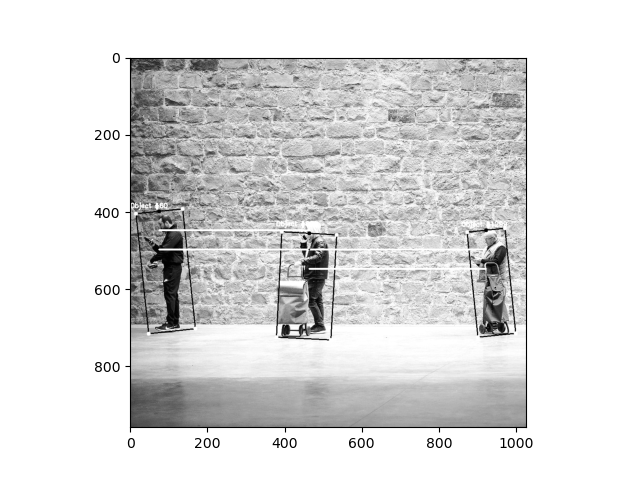

In [3]:
%matplotlib notebook 
peopleCounter("SocialDistance.pgm")

## 2)

dikdortgen boy x ekseni koordinatlari 894.5
dikdortgen boy x ekseni koordinatlari 2453.0
list of values [894.5, 2453.0]
new dist list [1558.5]


<IPython.core.display.Javascript object>


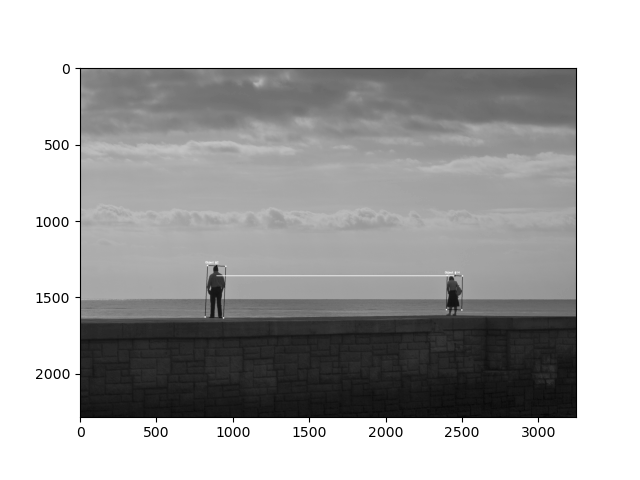

In [4]:
%matplotlib notebook 
peopleCounter("SocialDistance2.pgm")

## 3)

dikdortgen boy x ekseni koordinatlari 151.5
dikdortgen boy x ekseni koordinatlari 392.5
dikdortgen boy x ekseni koordinatlari 621.0
list of values [151.5, 392.5, 621.0]
new dist list [241.0, 228.5, 469.5]


<IPython.core.display.Javascript object>


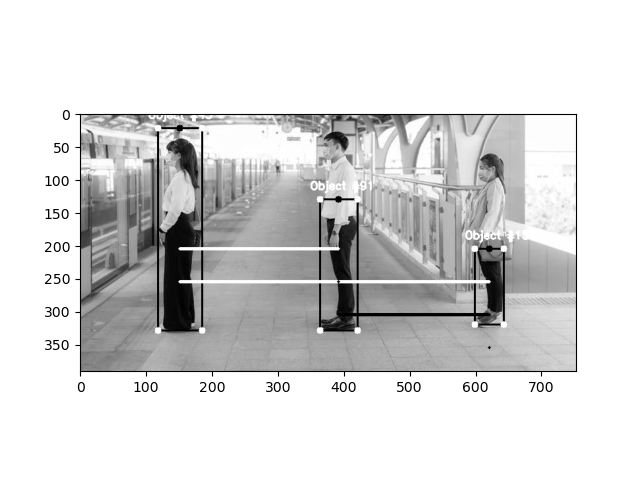

In [5]:
%matplotlib notebook 
peopleCounter("SocialDistance3.pgm")

## 4)

dikdortgen boy x ekseni koordinatlari 106.5
dikdortgen boy x ekseni koordinatlari 373.0
dikdortgen boy x ekseni koordinatlari 583.0
list of values [106.5, 373.0, 583.0]
new dist list [210.0, 266.5, 476.5]


<IPython.core.display.Javascript object>


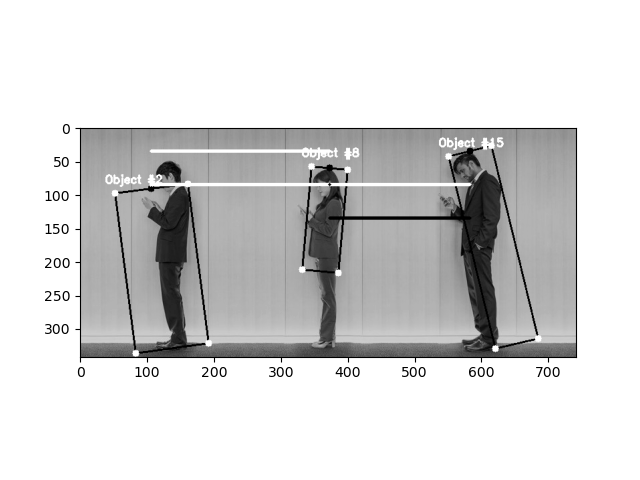

In [6]:
%matplotlib notebook 
peopleCounter("SocialDistance4.pgm")

## 5)

dikdortgen boy x ekseni koordinatlari 173.0
dikdortgen boy x ekseni koordinatlari 579.0
list of values [173.0, 579.0]
new dist list [406.0]


<IPython.core.display.Javascript object>


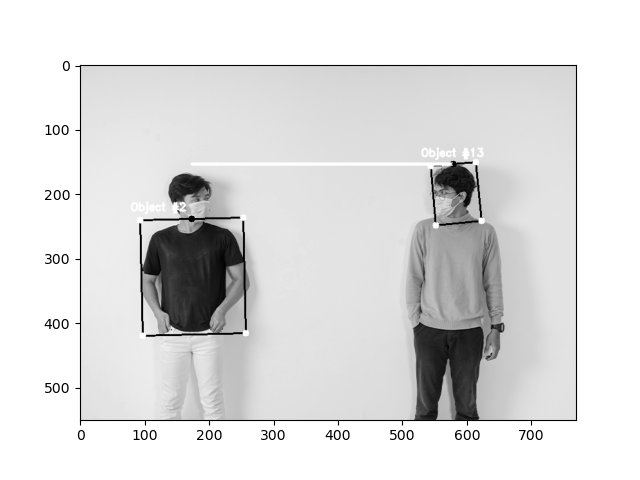

In [7]:
%matplotlib notebook 
peopleCounter("SocialDistance5.pgm")

## 6)

dikdortgen boy x ekseni koordinatlari 264.5
dikdortgen boy x ekseni koordinatlari 177.0
dikdortgen boy x ekseni koordinatlari 1085.0
list of values [264.5, 177.0, 1085.0]
new dist list [908.0, 820.5, 87.5]


<IPython.core.display.Javascript object>


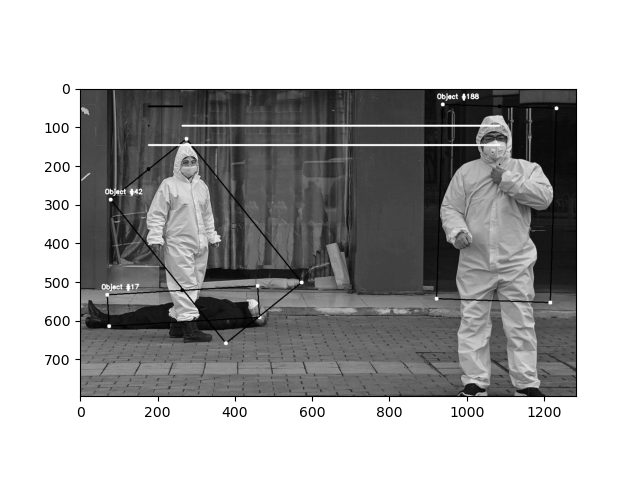

In [8]:
%matplotlib notebook 
peopleCounter("SocialDistance6.pgm")

## 7)

dikdortgen boy x ekseni koordinatlari 59.5
dikdortgen boy x ekseni koordinatlari 144.5
dikdortgen boy x ekseni koordinatlari 251.0
dikdortgen boy x ekseni koordinatlari 273.0
list of values [59.5, 144.5, 251.0, 273.0]
new dist list [128.5, 106.5, 213.5, 85.0, 22.0, 191.5]


<IPython.core.display.Javascript object>


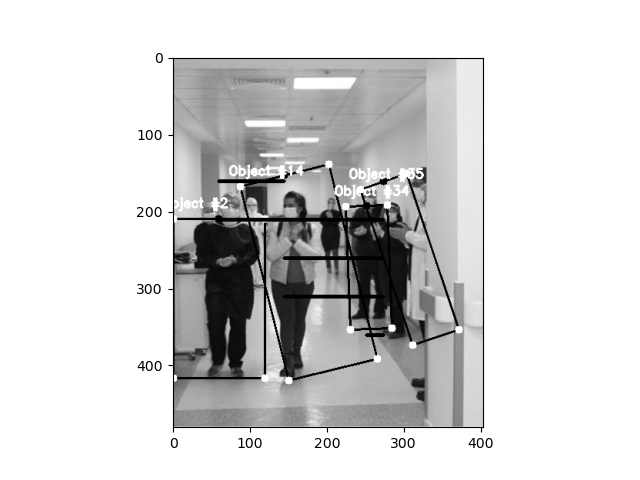

In [9]:
%matplotlib notebook 
peopleCounter("SocialDistance7.pgm")

## 8)

dikdortgen boy x ekseni koordinatlari 68.5
dikdortgen boy x ekseni koordinatlari 308.5
dikdortgen boy x ekseni koordinatlari 499.0
dikdortgen boy x ekseni koordinatlari 502.5
dikdortgen boy x ekseni koordinatlari 670.5
list of values [68.5, 308.5, 499.0, 502.5, 670.5]
new dist list [194.0, 3.5, 168.0, 362.0, 171.5, 430.5, 240.0, 434.0, 602.0, 190.5]


<IPython.core.display.Javascript object>


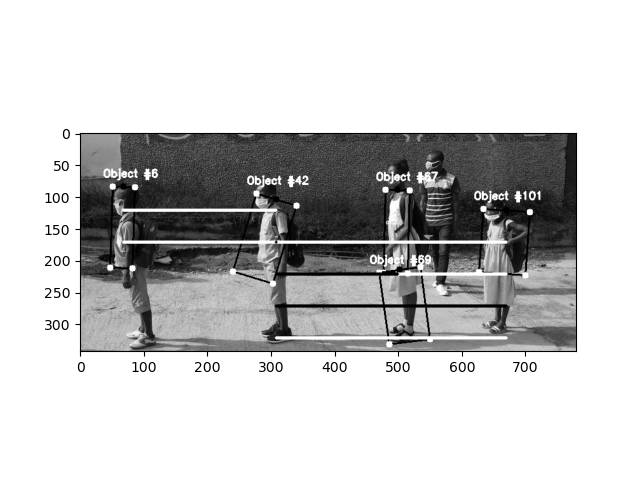

In [10]:
%matplotlib notebook 
peopleCounter("SocialDistance8.pgm")

## 9)

dikdortgen boy x ekseni koordinatlari 46.5
dikdortgen boy x ekseni koordinatlari 553.5
dikdortgen boy x ekseni koordinatlari 144.5
dikdortgen boy x ekseni koordinatlari 210.0
dikdortgen boy x ekseni koordinatlari 399.5
dikdortgen boy x ekseni koordinatlari 1144.0
dikdortgen boy x ekseni koordinatlari 1238.0
dikdortgen boy x ekseni koordinatlari 1309.0
list of values [46.5, 553.5, 144.5, 210.0, 399.5, 1144.0, 1238.0, 1309.0]
new dist list [1028.0, 1164.5, 909.5, 409.0, 154.0, 163.5, 165.0, 934.0, 1191.5, 684.5, 189.5, 65.5, 1093.5, 838.5, 71.0, 1097.5, 1099.0, 590.5, 343.5, 94.0, 353.0, 98.0, 999.5, 744.5, 1262.5, 755.5, 507.0, 255.0]


<IPython.core.display.Javascript object>


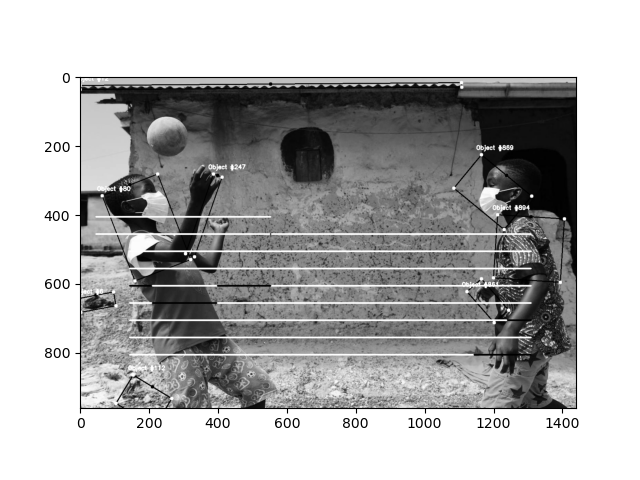

In [11]:
%matplotlib notebook 
peopleCounter("SocialDistance9.pgm")

## 10)

dikdortgen boy x ekseni koordinatlari 145.0
dikdortgen boy x ekseni koordinatlari 358.0
list of values [145.0, 358.0]
new dist list [213.0]


<IPython.core.display.Javascript object>


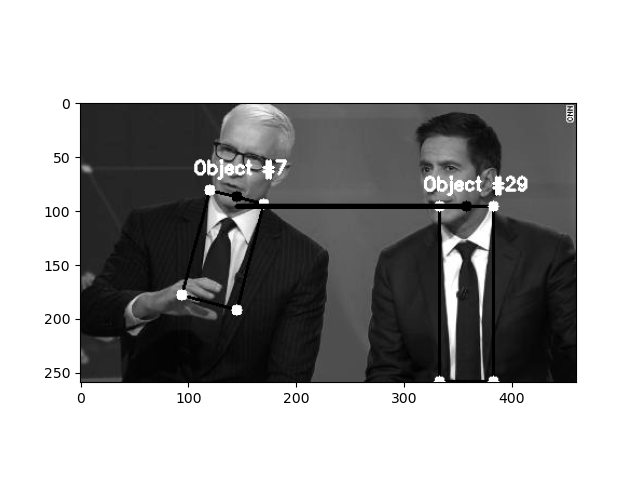

In [12]:
%matplotlib notebook 
peopleCounter("SocialDistance10.pgm")